In [66]:
import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)
def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target
    
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 10)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

if torch.cuda.is_available():
    device = "cuda"

net = LeNet().to(device)
    
net.apply(weights_init)

dst = datasets.CIFAR10("~/data", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

img_index = 1000
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=10)

1.12.1+cu116 0.13.1+cu116
Files already downloaded and verified


GT label is 9. 
Onehot label is 9.


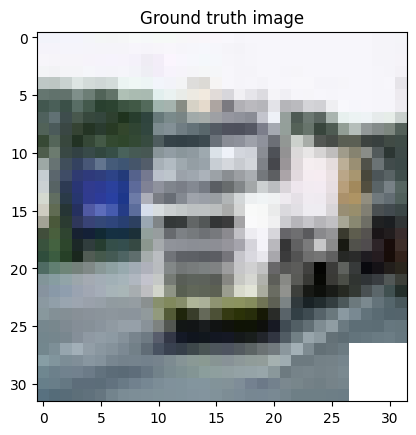

In [67]:
# plt.imshow(tt(gt_data[0].cpu()))
gt_data[:,:,27:32,27:32]=1
plt.imshow(tt(gt_data[0]))

plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())


Dummy label is 7.
abc


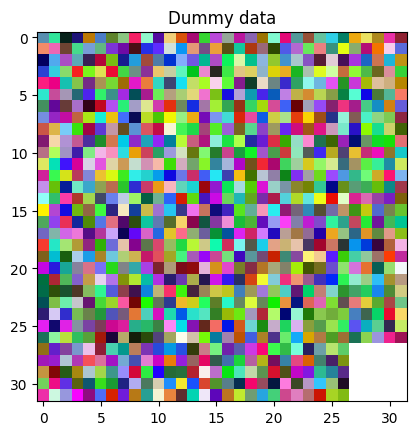

In [68]:
# generate dummy data and label

# dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_data = torch.randn(gt_data.size())
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
dummy_data[:,:,27:32,27:32]=1

plt.imshow(tt(dummy_data[0]))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

# compute original gradient 
out = net(gt_data)
print('abc')

In [69]:
def criterion(target,threshold=20):
    return torch.abs(target-threshold)

In [75]:
gt_data=gt_data.to(device)
# gt_data[:,:,27:32,27:32].requires_grad = True
# optimizer = torch.optim.LBFGS([gt_data[:,:,27:32,27:32]],lr=0.1)
optimizer = torch.optim.Adam([gt_data[:,:,27:32,27:32]],lr=0.1)


history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()
        pred = net(gt_data) 
        # print(pred[0][0])
        print(pred)
        loss = criterion(pred[0][0])
        loss.backward()  
        return loss
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(gt_data[0].cpu()))

tensor([[ 6.5627,  2.2495, -1.7074, -0.0856, -5.0267, -0.5969, -3.7533, -1.3434,
          0.4289, -0.2872]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 6.5627,  2.2495, -1.7074, -0.0856, -5.0267, -0.5969, -3.7533, -1.3434,
          0.4289, -0.2872]], device='cuda:0', grad_fn=<AddmmBackward0>)
0 13.4373
tensor([[ 6.5627,  2.2495, -1.7074, -0.0856, -5.0267, -0.5969, -3.7533, -1.3434,
          0.4289, -0.2872]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 6.5627,  2.2495, -1.7074, -0.0856, -5.0267, -0.5969, -3.7533, -1.3434,
          0.4289, -0.2872]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 6.5627,  2.2495, -1.7074, -0.0856, -5.0267, -0.5969, -3.7533, -1.3434,
          0.4289, -0.2872]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 6.5627,  2.2495, -1.7074, -0.0856, -5.0267, -0.5969, -3.7533, -1.3434,
          0.4289, -0.2872]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 6.5627,  2.2495, -1.7074, -0.0856, -5.0267, -0.5969, -3.7533, 

Dummy label is 7.


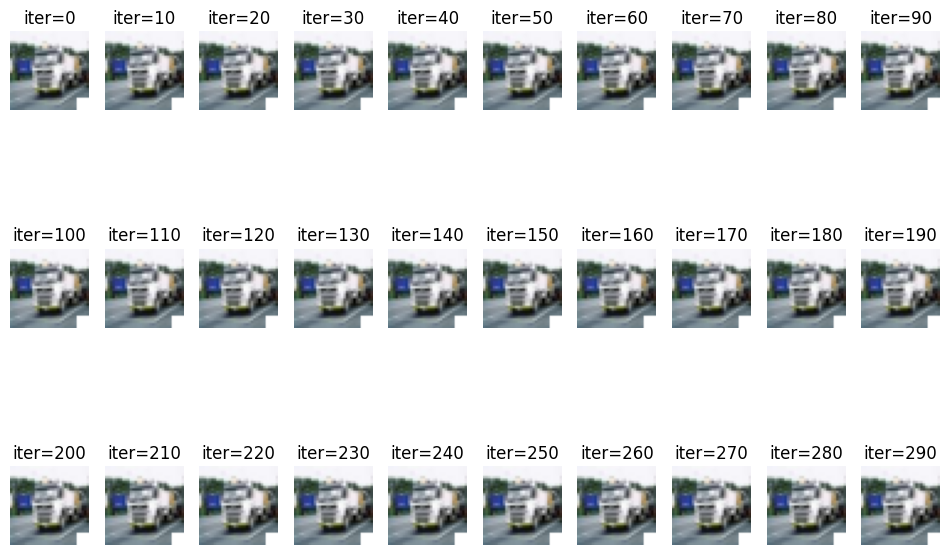

In [71]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())